## Training a Convolutional Neural Network (CNN) on MNIST Dataset

We begin with building a CNN network for image classification task on MNIST dataset. In the first part of the tutorial, we will try to understand the MNIST digit classfication dataset. Then we'll understand how to build a CNN network, define an appropiate loss, and train the network with back-propagation. Finally, we will use the trained model to test on a test dataset.

**Step 1:** We need to import all the required libraries

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt


cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.0 CUDA: False


**Step 2:** We need to load the MNIST data. In this tutorial, we'll be using Pytorch's dataloader to load and format the MNIST dataset. First time we may have to download the dataset, which may take a while. 

For more details, please refer: 
- https://pytorch.org/docs/0.3.0/data.html?highlight=dataloader#torch.utils.data.DataLoader
- https://pytorch.org/docs/0.3.0/torchvision/datasets.html?highlight=dataset

In [2]:
batch_size = 10 # no. of examples to be processed at once on GPU

# Define the dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/step/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/step/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

**Step 3:** Visualize the dataset

- MNIST is a simple computer vision dataset. It consists of 28x28 pixel images of handwritten digits
- The train and test data are provided via data loaders that provide iterators over the datasets. 
- The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. 
- y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

For more visualizations and to get more insight on the MNIST dataset you may refer to this link: http://colah.github.io/posts/2014-10-Visualizing-MNIST/

In [3]:
print("No. of Training examples:", len(train_loader)*batch_size)
print("No. of Testing examples:", len(test_loader)*batch_size)
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

No. of Training examples: 60000
No. of Testing examples: 10000
X_train: torch.Size([10, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([10]) type: torch.LongTensor


Here are the first 10 digits

/home/pratik/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


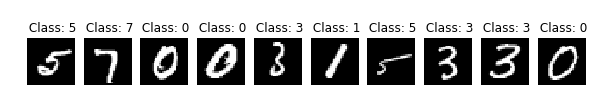

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.gca().set_title('\n Class: '+str(y_train[i].data[0].numpy()))
    

**Step 3:** Define the MLP network

![alt text](mnist_lenet.jpg "Logo Title Text 1")


- Here, we define a single layer MLP network (you are free to add few more layers)
- We have to write the \__init__() and forward() methods
- Pytorch will automatically generate the gradients when we call the backward() method for backward pass


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1   = nn.Linear(50*4*4, 500)
        self.fc2   = nn.Linear(500, 10)
        

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

model = LeNet()
if cuda:
    model.cuda()

**Step 4:** Define an optimizer
You can change the optimizers. Refer to the following links to know more about the available optimizers- https://pytorch.org/docs/0.3.0/optim.html#algorithms.

Here, we are using Stochastic Gradient Descent (SGD)


In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

**Step 5:** Define a suitable loss function.

    We will be using the Cross-Entropy loss function.     
    https://pytorch.org/docs/0.3.0/nn.html?highlight=cross%20entropy#torch.nn.functional.cross_entropy

In [7]:
loss_func = nn.CrossEntropyLoss()

**Step 6:** Training method. We will use this method to train our model

In [8]:
def train(epoch, log_interval=1000):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [9]:
def test(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += loss_func(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

**Step 7:** Now, we are ready to train our first ever modelusing the train() function. 

Epoch: An epoch means  one pass through the whole training data. After each epoch, we'll evaluate our model on the test dataset.

In [10]:
%%time
epochs = 10

lossv, accv = [], [] # used to keep track of train progress (used in the next cell)
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)


/home/pratik/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306702
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.038506
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.738053
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.009625
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.088170
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.042360


/home/pratik/.virtualenvs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':



Validation set: Average loss: 0.0516, Accuracy: 9827/10000 (98.0000%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.012695
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.014897
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.003447
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.000420
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000199
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.007916

Validation set: Average loss: 0.0358, Accuracy: 9883/10000 (98.0000%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.021275
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.000293
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.000273
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.030022
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.000224
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.000638

Validation set: Average loss: 0.0289, Accuracy: 9903/10000 (99.0000%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002193
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.000112
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.004332
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.002510

**Step 8:** Now, as training is done, let us visualizae the training progress graphically

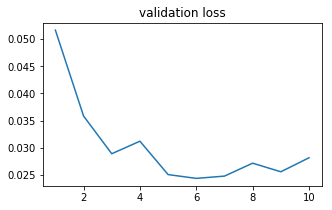

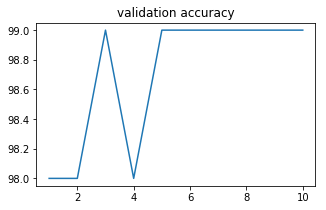

In [11]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');


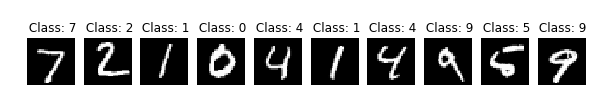

In [13]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

X_test, y_test = iter(test_loader).next()
predicted_labels = model(Variable(X_test))
                         
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_test[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.gca().set_title('\n Class: '+str(predicted_labels.cpu().data.max(1)[1][i].data.numpy()))